In [ ]:
# 本代码用于展示DDPM的工作过程，为了进行更全面的展示，方便复现，代码分为三个部分

# 1. 严格按照DDPM定义的扩散过程在CIFAR10数据集上的实验

# 2. 严格按照DDPM定义的扩散过程在MNIST数据集上的实验，
#    进行这部分实验是因为在CIFAR10上需要的训练时间较长，
#    MNIST是相对更简单的数据集，更容易较快看到DDPM的效果。

# 3. 一种近似的扩散过程，在CIFAR10数据集上的实验，
#    这部分实验没有严格按照DDPM的过程进行，但扩散模型的思路
#    是被保留的，可以更快地看到扩散模型在较复杂的CIFAR10上的效果。

In [ ]:
################################
# 首先是通用的导入依赖和实验设定过程 #
################################

In [1]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

/home/gaog/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
# 第一部分实验
# DDPM+CIFAR10

In [4]:
# 实验基础设定

IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size

device = torch.device('cuda')

In [5]:
# 使用pytorch自带的CIFAR10数据集
# 首次运行需要下载

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])  # 对图片进行基础的转换

# 导入（和下载）数据集
all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 挑选出某一类别的图片
# 训练数据的图片类别决定了生成的内容是什么
# 这里label==1挑出来的是“汽车”的图片
# 也可以使用所有label的数据进行训练，但需要更长的训练时间
idx = [i for i, (img, label) in enumerate(all_trainset) if label == 1]
sub_trainset = torch.utils.data.Subset(all_trainset, idx)

# 使用pytorch的DataLoader进行封装，方便后续训练调用
trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


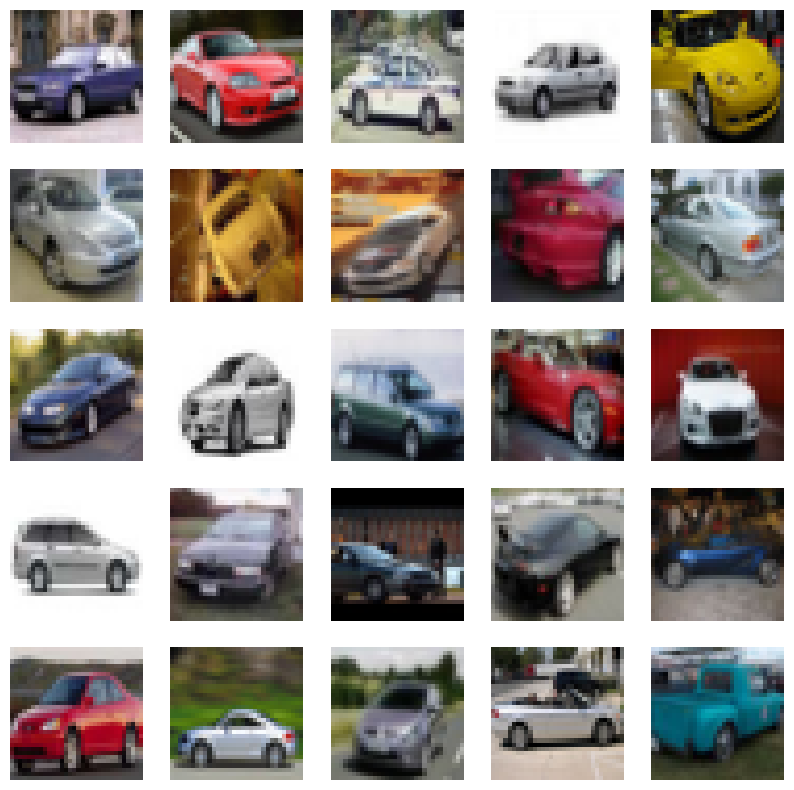

In [6]:
def cvtImg(img):
    # 对照片进行必要的转换以通过plt.imshow()进行展示
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    # 展示任意给定的图片
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)

In [7]:
# DDPM中的做法，这种做法需要的训练时间较长，对参数设置比较敏感
# 后续对这种做法进行了很多改进，为了方便展示，后面使用比较便捷的方法

def linear_beta_schedule(timesteps):
    """
    linear schedule, proposed in original ddpm paper
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

betas = linear_beta_schedule(1000)
timesteps=1000

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

def forward_noise(x, t):
    """
        forward process
    """
    noise = np.random.normal(size=x.shape)  # noise mask
    a = alphas_cumprod[t].numpy()
    a = a.reshape((-1, 1, 1, 1))
    img_a = x * np.sqrt(a) + noise * np.sqrt(1-a)
    return img_a, noise

def generate_ts(num):
    """
        randomly get a timestep
    """
    return np.random.randint(0, timesteps, size=num)

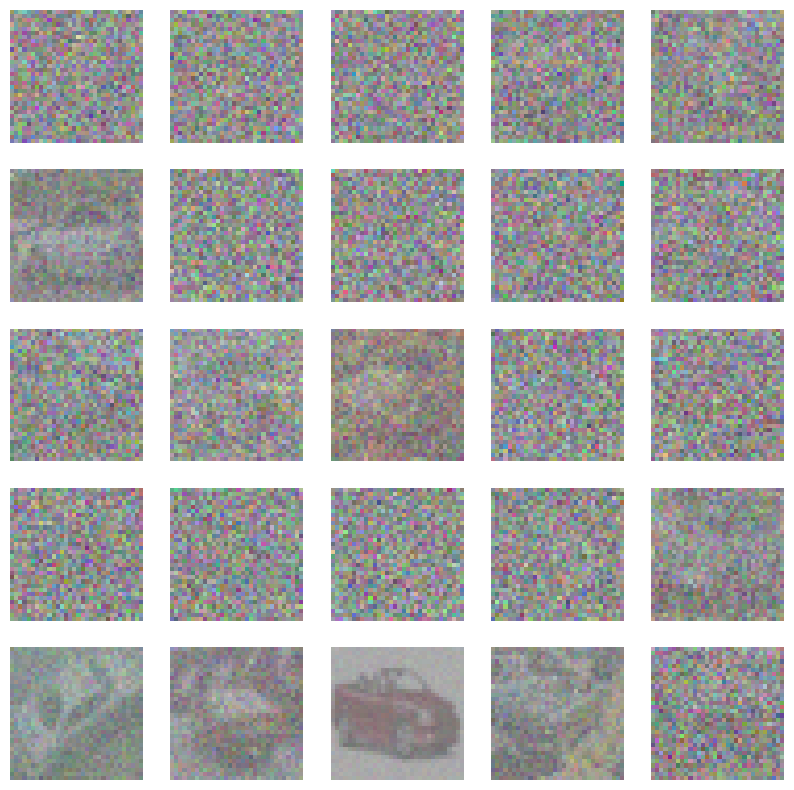

In [8]:
t = generate_ts(25)
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)

In [9]:
# 定义用于预测噪声的模型，对于图片，一般使用UNet模型

# UNet的组件
class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()
        
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

# UNet模型
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )
        
        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)
        
        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),
            
            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )
        
        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)
        
        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
        
        # make optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=2e-4)
    
    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)
        
        # ----- left ( down ) -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)
                
        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)
        
        # ----- right ( up ) -----
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]
        
        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)
            
            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')
                
        # ----- output -----
        x = self.cnn_output(x)

        return x

In [10]:
model = Model().to(device)

In [11]:
# 定义反向过程，即生成图片的过程
def predict():
    """
        reverse process
    """
    x = torch.randn(25, 3, IMG_SIZE, IMG_SIZE).to(device)
    with torch.no_grad():
        for t in trange(timesteps-1,-1,-1):
            pred_noise = model(x, torch.full([25, 1], t, dtype=torch.float, device=device))
            meancoef1 = 1/np.sqrt(alphas[t])
            meancoef2 = (1-alphas[t])/(np.sqrt(1-alphas_cumprod[t]))
            varcoef = np.sqrt(betas[t])
            noise = torch.randn_like(x)
            x = meancoef1*(x-meancoef2*pred_noise)+varcoef*noise

    show_examples(x.cpu())

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 175.77it/s]


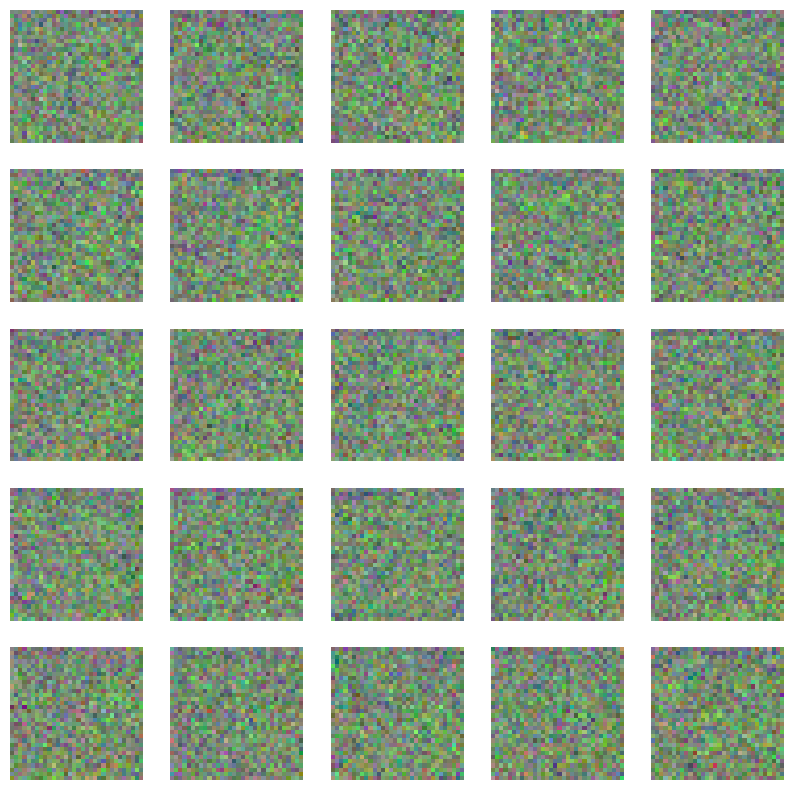

In [12]:
predict()

In [13]:
# 反向过程，与predict的区别是展现一个图片从噪声到内容的详细过程
def predict_step():
    """
        reverse process and show the process
    """
    xs = []
    x = torch.randn(size=(1, 3, IMG_SIZE, IMG_SIZE), device=device)

    with torch.no_grad():
        for t in trange(timesteps-1,-1,-1):
            pred_noise = model(x, torch.full([25, 1], t, dtype=torch.float, device=device))
            meancoef1 = 1/np.sqrt(alphas[t])
            meancoef2 = (1-alphas[t])/(np.sqrt(1-alphas_cumprod[t]))
            varcoef = np.sqrt(betas[t])
            noise = torch.randn_like(x)
            x = meancoef1*(x-meancoef2*pred_noise)+varcoef*noise
            if t % 100 == 0:
                xs.append(x[1].cpu())
    xs = torch.stack(xs, dim=0)
    plt.figure(figsize=(20, 3))
    imgs = cvtImg(xs)
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(imgs[i])
        plt.title(f'{i+1}')
        plt.axis('off')

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.53it/s]


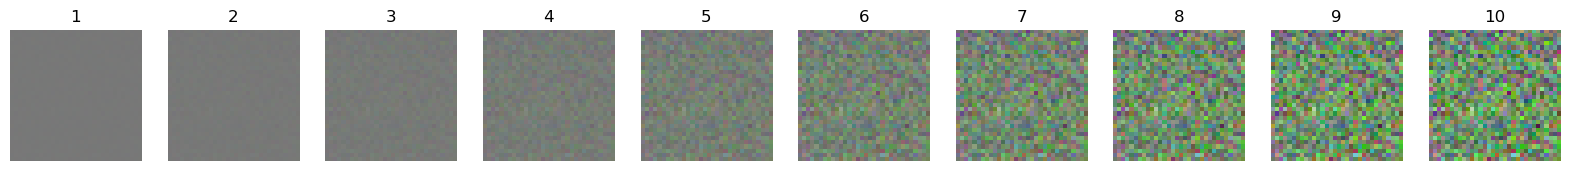

In [14]:
predict_step()

In [15]:
# 定义训练过程

def train_one(x_img):
    """
        one-step train
    """
    x_ts = generate_ts(len(x_img))
    x_a, noise = forward_noise(x_img, x_ts)
    
    x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
    x_a = x_a.float().to(device)
    noise = torch.from_numpy(noise)
    noise = noise.float().to(device)
    
    y_p = model(x_a, x_ts)
    loss = torch.mean((y_p - noise)**2)
    model.opt.zero_grad()
    loss.backward()
    model.opt.step()
    
    return loss.item()

def train(R=200):
    """
        train R epochs
    """
    bar = trange(R)
    total = len(trainloader)
    for i in bar:
        for j, (x_img, _) in enumerate(trainloader):
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [ ]:
# 进行模型的训练
for _ in range(35):
    train()
    # show result 
    predict()
    predict_step()
    plt.show()

In [ ]:
# 保存模型
# torch.save(model.state_dict(), "./models/DDPM_CIFAR_1.ckp")

In [16]:
model.load_state_dict(torch.load("./models/DDPM_CIFAR_1.ckp"))

<All keys matched successfully>

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 227.59it/s]


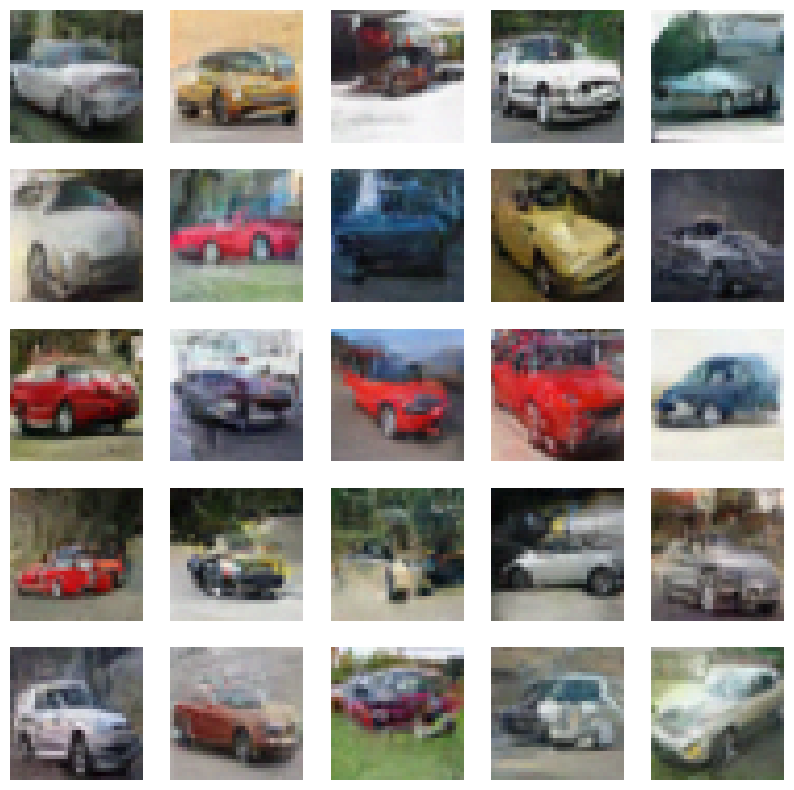

In [18]:
predict()

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.48it/s]


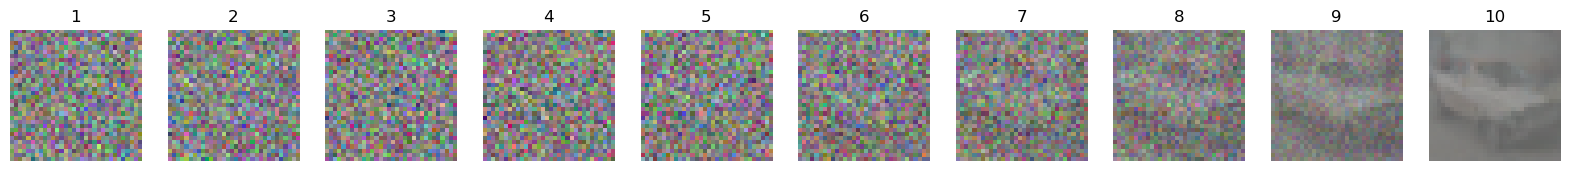

In [20]:
predict_step()

In [ ]:
# 第二部分实验
# DDPM+MNIST

In [ ]:
# 这部分实验与上述过程是完全一致的，只是调整了和MNIST数据相关的部分

In [ ]:
# 使用pytorch自带的MNIST数据集
# 首次运行需要下载

# 导入（和下载）数据集
all_trainset = torchvision.datasets.MNIST(root="./MNIST", train=True, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),  # 转换成张量
                                    ]))

# 使用pytorch的DataLoader进行封装，方便后续训练调用
trainloader = torch.utils.data.DataLoader(all_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
# 实验基础设定

IMG_SIZE = 28     # input image size, MNIST is 28x28

In [ ]:
x, _ = next(iter(trainloader))
show_examples(x)

In [ ]:
# 因为图片大小发生了变化，UNet参数设置也发生了变化
# 在工程应用中，建议把UNet的参数以形参的形式定义
# 本代码中直接写死成固定的参数，不建议使用这种做法

# UNet的组件
class Block(nn.Module):
    def __init__(self, in_channels=128, size=28):
        super(Block, self).__init__()
        
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out
# UNet模型
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )
        
        self.down_x32 = Block(in_channels=1, size=28)
        self.down_x16 = Block(size=14)
        self.down_x8 = Block(size=7)
        
        self.mlp = nn.Sequential(
            nn.Linear(6464, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),
            
            nn.Linear(128, 28 * 7 * 7), # make [-1, 32, 4, 4]
            nn.LayerNorm([28 * 7 * 7]),
            nn.ReLU(),
        )
        
        self.up_x8 = Block(in_channels=28 + 128, size=7)
        self.up_x16 = Block(in_channels=256, size=14)
        self.up_x32 = Block(in_channels=256, size=28)
        
        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        
        # make optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=0.000002)
    
    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts).squeeze()
        
        # ----- left ( down ) -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)
                
        # ----- MLP -----
        x = x.view(-1, 128 * 7 * 7)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 28, 7, 7)
        
        # ----- right ( up ) -----
        blocks = [
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]
        
        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)
            
            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')
                
        # ----- output -----
        x = self.cnn_output(x)

        return x

In [ ]:
model = Model().to(device)

In [ ]:
# 定义反向过程，即生成图片的过程
def predict():
    """
        reverse process
    """
    x = torch.randn(25, 1, IMG_SIZE, IMG_SIZE).to(device)
    with torch.no_grad():
        for t in trange(timesteps-1,-1,-1):
            pred_noise = model(x, torch.full([25, 1], t, dtype=torch.float, device=device))
            meancoef1 = 1/np.sqrt(alphas[t])
            meancoef2 = (1-alphas[t])/(np.sqrt(1-alphas_cumprod[t]))
            varcoef = np.sqrt(betas[t])
            noise = torch.randn_like(x)
            x = meancoef1*(x-meancoef2*pred_noise)+varcoef*noise

    show_examples(x.cpu())

In [ ]:
# 反向过程，与predict的区别是展现一个图片从噪声到内容的详细过程
def predict_step():
    """
        reverse process and show the process
    """
    xs = []
    x = torch.randn(size=(1, 1, IMG_SIZE, IMG_SIZE), device=device)

    with torch.no_grad():
        for t in trange(timesteps-1,-1,-1):
            pred_noise = model(x, torch.full([25, 1], t, dtype=torch.float, device=device))
            meancoef1 = 1/np.sqrt(alphas[t])
            meancoef2 = (1-alphas[t])/(np.sqrt(1-alphas_cumprod[t]))
            varcoef = np.sqrt(betas[t])
            noise = torch.randn_like(x)
            x = meancoef1*(x-meancoef2*pred_noise)+varcoef*noise
            if t % 100 == 0:
                xs.append(x[1].cpu())
    xs = torch.stack(xs, dim=0)
    plt.figure(figsize=(20, 3))
    imgs = cvtImg(xs)
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(imgs[i])
        plt.title(f'{i+1}')
        plt.axis('off')

In [ ]:
# 进行模型的训练
for _ in range(3):
    train(R=50)
    # show result 
    predict()
    predict_step()
    plt.show()

In [ ]:
# 保存模型
# torch.save(model.state_dict(), "./models/DDPM_MNIST_all.ckp")

In [ ]:
model.load_state_dict(torch.load("./models/DDPM_MNIST_all.ckp"))

In [ ]:
predict()
predict_step()
plt.show()

In [ ]:
# 第三部分实验
# 一种近似的扩散过程+CIFAR10

In [ ]:
# 使用pytorch自带的CIFAR10数据集
# 首次运行需要下载

IMG_SIZE = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])  # 对图片进行基础的转换

# 导入（和下载）数据集
all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 挑选出某一类别的图片
# 训练数据的图片类别决定了生成的内容是什么
# 这里label==1挑出来的是“汽车”的图片
# 也可以使用所有label的数据进行训练，但需要更长的训练时间
idx = [i for i, (img, label) in enumerate(all_trainset) if label == 1]
sub_trainset = torch.utils.data.Subset(all_trainset, idx)

# 使用pytorch的DataLoader进行封装，方便后续训练调用
trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
# 直接指定原始数据与噪声的线性加权权重

timesteps = 32    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

def forward_noise(x, t):
    """
        前向增加噪声的过程
    """
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

t = generate_ts(25)             # random for training data
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)

In [ ]:
# 定义用于预测噪声的模型，对于图片，一般使用UNet模型

# UNet的组件
class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()
        
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

# UNet模型
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )
        
        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)
        
        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),
            
            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )
        
        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)
        
        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
        
        # make optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)
    
    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)
        
        # ----- left ( down ) -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)
                
        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)
        
        # ----- right ( up ) -----
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]
        
        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)
            
            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')
                
        # ----- output -----
        x = self.cnn_output(x)

        return x

In [ ]:
model = Model().to(device)

In [ ]:
def predict(x_idx=None):
    x = torch.randn(32, 3, IMG_SIZE, IMG_SIZE).to(device)
    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([32, 1], t, dtype=torch.float, device=device))

    show_examples(x.cpu())

In [ ]:
predict()

In [ ]:
def predict_step():
    xs = []
    x = torch.randn(size=(8, 3, IMG_SIZE, IMG_SIZE), device=device)

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

In [ ]:
predict_step()

In [ ]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    
    x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
    x_a = x_a.float().to(device)
    x_b = x_b.float().to(device)
    
    y_p = model(x_a, x_ts)
    loss = torch.mean(torch.abs(y_p - x_b))
    model.opt.zero_grad()
    loss.backward()
    model.opt.step()
    
    return loss.item()

def train(R=50):
    bar = trange(R)
    total = len(trainloader)
    for i in bar:
        for j, (x_img, _) in enumerate(trainloader):
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [ ]:
for _ in range(10):
    train()
    # reduce learning rate for next training
    for pg in model.opt.param_groups:
        pg['lr'] = max(0.000001, pg['lr'] * 0.9)
    # show result 
    predict()
    predict_step()
    plt.show()

In [ ]:
# 保存模型
# torch.save(model.state_dict(), "./models/APPROX_CIFAR_1.ckp")

In [ ]:
model.load_state_dict(torch.load("./models/APPROX_CIFAR_1.ckp"))

In [ ]:
predict()
predict_step()
plt.show()